In [ ]:
import numpy as np
import pandas as pd

import time, warnings
import datetime as dt

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

%matplotlib inline

warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Get the Data

In [ ]:
#load the dataset
retail_df = pd.read_csv('/content/drive/MyDrive/Dataset/uk-ecommerce.csv',
                        encoding='ISO-8859-1',
                        dtype={'CustomerID': str, 'InvoiceID': str})
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


# EDA

In [ ]:
retail_df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID      object
Country         object
dtype: object

In [ ]:
retail_df['InvoiceDate']= pd.to_datetime(retail_df['InvoiceDate']).dt.date

In [ ]:
#Checking Null Values
retail_df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
retail_df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


It appears that there are Negative Quantity & Negative Unitprice

In [ ]:
# Check the Negative Order Quantity
retail_df[retail_df.Quantity < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09,1.25,17315,United Kingdom


In [ ]:
# Check the Negative Unit Price
retail_df[retail_df.UnitPrice < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12,-11062.06,NaN,United Kingdom


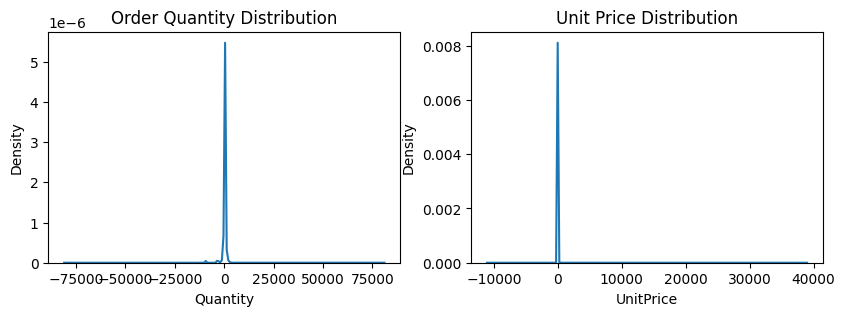

In [ ]:
fig= plt.figure(figsize=(10,3))

ax= fig.add_subplot(121)
sns.kdeplot(retail_df.Quantity, ax=ax)
ax.set_title('Order Quantity Distribution')

ax= fig.add_subplot(122)
sns.kdeplot(retail_df.UnitPrice, ax=ax)
ax.set_title('Unit Price Distribution')

plt.show()

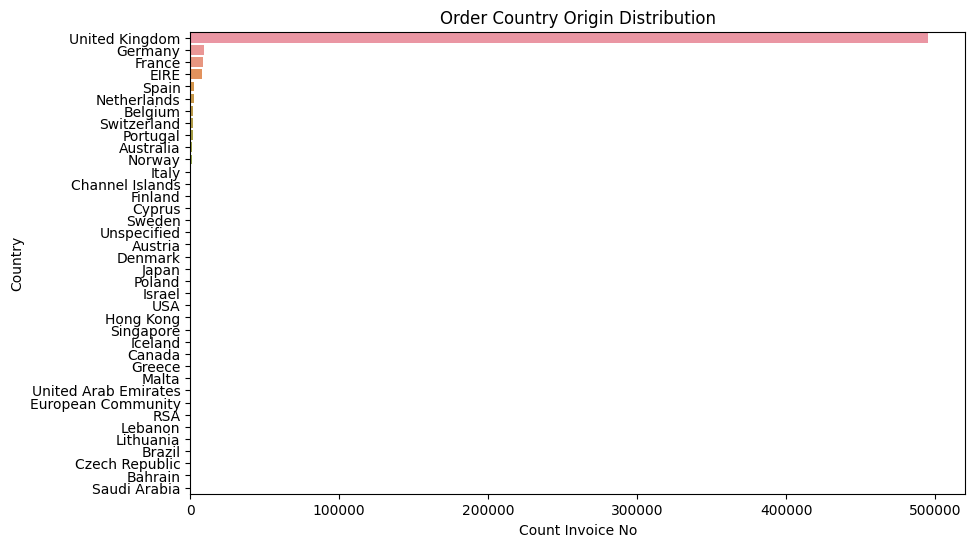

In [ ]:
data =  retail_df.groupby('Country').agg({'InvoiceNo':'count'}).sort_values('InvoiceNo', ascending=False)

plt.figure(figsize=(10,6))

plt.title('Order Country Origin Distribution')
sns.barplot(y=data.index, x=data.InvoiceNo)
plt.xlabel('Count Invoice No')
plt.show()

# Prepare the Data

As customers clusters may vary by geography, I'll restrict the data to only United Kingdom customers, which contains most of our customers histrocal data.

In [ ]:
retail_uk = retail_df[retail_df['Country'] == 'United Kingdom']
# check the shape
retail_uk.shape

(495478, 8)

In [ ]:
# remove canceled orders
retail_uk = retail_uk[retail_uk['Quantity'] > 0]
retail_uk.shape

(486286, 8)

In [ ]:
# remove rows where customers ID are NA
retail_uk.dropna(subset=['CustomerID'], how='all', inplace=True)
retail_uk.shape

(354345, 8)

In [ ]:
print(retail_uk['InvoiceDate'].max())
print(retail_uk['InvoiceDate'].min())

2011-12-09
2010-12-01


In [ ]:
#restrict the data to one full year because it's better to use a metric per Months or Years in RFM
retail_uk = retail_uk[retail_uk['InvoiceDate'] >= dt.date(2010,12,9)]
retail_uk.shape

(342478, 8)

In [ ]:
print("Summary ..")
# exploring the nunique values of each attribute
print("Number of transactions:", retail_uk['InvoiceNo'].nunique())
print("Number of product bought:", retail_uk['StockCode'].nunique())
print("Number of customers:", retail_uk['CustomerID'].nunique())
print("Percentage of customers NA:", round(retail_uk['CustomerID'].isnull().sum() * 100 / len(retail_df),2),"%")

Summary ..
Number of transactions: 16017
Number of product bought: 3611
Number of customers: 3863
Percentage of customers NA: 0.0 %


# RFM Analysis

**RFM** (Recency, Freqeuncy, Monetary) analysis is a customer segmentation technique that uses past purchase behivior to divide customers into groups. RFM helps divide customers into various-categories or clusters to idnetify customers who are more likely to respond to promotions and also for future personaliztion services.



*   RECENCY (R): Days since last purchase
*   FREQUENCY (F): Total number of purchases
*   MONETARY VALUE (M): Total money this customers spent

We will create those 3 customers attributes for each customers.




# Recency

To calculate recency, we need to choose a date point from which we evaluate **how many days ago was the customer's last purchase.**

In [ ]:
# last date available in our dataset
retail_uk['InvoiceDate'].max()

datetime.date(2011, 12, 9)

The last date we have is 2011-12-09 so we will use it as reference

In [ ]:
now = retail_uk['InvoiceDate'].max()
print(now)

2011-12-09


In [ ]:
# create a new column date which contains the date of invoice only
retail_uk['date'] = retail_uk['InvoiceDate']

In [ ]:
retail_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date
19632,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09,3.95,14243,United Kingdom,2010-12-09
19633,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09,4.65,14243,United Kingdom,2010-12-09
19634,537879,85150,LADIES & GENTLEMEN METAL SIGN,6,2010-12-09,2.55,14243,United Kingdom,2010-12-09
19635,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09,7.95,14243,United Kingdom,2010-12-09
19636,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09,7.95,14243,United Kingdom,2010-12-09


In [ ]:
# group by customers and check last date of purchase
recency_df = retail_uk.groupby(by='CustomerID', as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurchaseDate']
recency_df

,CustomerID,LastPurchaseDate
0,12346,2011-01-18
1,12747,2011-12-07
2,12748,2011-12-09
3,12749,2011-12-06
4,12820,2011-12-06
...,...,...
3858,18280,2011-03-07
3859,18281,2011-06-12
3860,18282,2011-12-02
3861,18283,2011-12-06


In [ ]:
# calculate recency
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x: (now-x).days)

In [ ]:
recency_df.head()

,CustomerID,LastPurchaseDate,Recency
0,12346,2011-01-18,325
1,12747,2011-12-07,2
2,12748,2011-12-09,0
3,12749,2011-12-06,3
4,12820,2011-12-06,3


In [ ]:
# drop LastPurchaseDate as we don't need it anymore
recency_df.drop('LastPurchaseDate', axis=1, inplace=True)

In [ ]:
recency_df.head()

,CustomerID,Recency
0,12346,325
1,12747,2
2,12748,0
3,12749,3
4,12820,3


# Frequency

Frequency helps us to know how many times a customers purchased from us. To do that we need to check **how many invoices are rgeistered by the same customer.**

In [ ]:
# drop duplicates
retail_uk_copy =  retail_uk
retail_uk_copy.drop_duplicates(subset=['InvoiceNo','CustomerID'], keep='first', inplace=True)

In [ ]:
#calculate frequency  of purchases
frequency_df = retail_uk_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID', 'Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346,1
1,12747,10
2,12748,196
3,12749,5
4,12820,4


# Monetary

Monetary attribute answers the question: **How much money did teh customer spent ovet time?**

To do that first, we will create a new column total cost to have the total price per invoice

In [ ]:
# create column total cost
retail_uk['TotalCost'] = retail_uk['Quantity'] * retail_uk['UnitPrice']

In [ ]:
monetary_df = retail_uk.groupby(by=['CustomerID'], as_index=False).agg({'TotalCost':'sum'})
monetary_df.columns = ['CustomerID', 'Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346,77183.60
1,12747,658.89
2,12748,3739.23
3,12749,98.35
4,12820,58.20


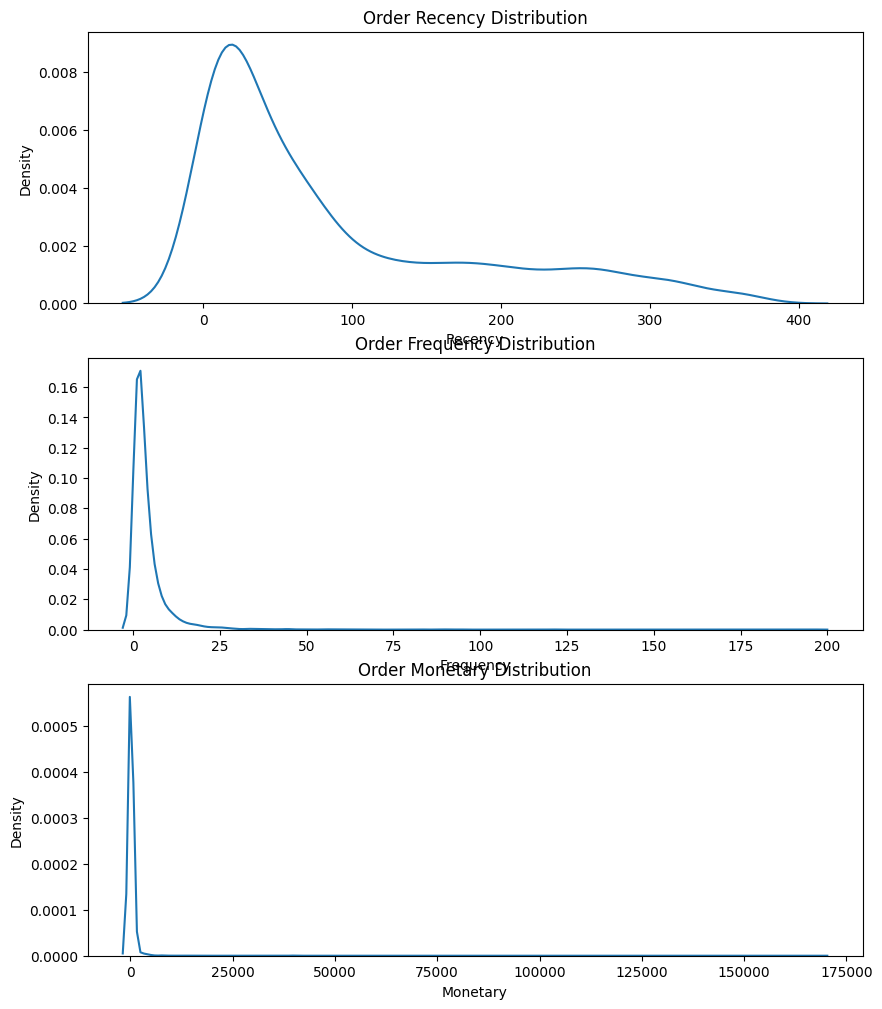

In [ ]:
fig= plt.figure(figsize=(10,12))

# Recency
ax= fig.add_subplot(311)
sns.kdeplot(recency_df.Recency, ax=ax)
ax.set_title('Order Recency Distribution')

# Frequency
ax= fig.add_subplot(312)
sns.kdeplot(frequency_df.Frequency, ax=ax)
ax.set_title('Order Frequency Distribution')

# Monetary
ax= fig.add_subplot(313)
sns.kdeplot(monetary_df.Monetary, ax=ax)
ax.set_title('Order Monetary Distribution')

plt.show()

# Create RFM Table

In [ ]:
# merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df, on='CustomerID')
temp_df.head()

,CustomerID,Recency,Frequency
0,12346,325,1
1,12747,2,10
2,12748,0,196
3,12749,3,5
4,12820,3,4


In [ ]:
# merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df, on='CustomerID')
# use CustomersID  as index
rfm_df.set_index('CustomerID', inplace=True)
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,77183.60
12747,2,10,658.89
12748,0,196,3739.23
12749,3,5,98.35
12820,3,4,58.20


# RFM Table Correctness Verification

In [ ]:
retail_uk[retail_uk['CustomerID'] == '12820']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,TotalCost
59368,541283,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,2011-01-17,0.55,12820,United Kingdom,2011-01-17,13.2
360567,568236,23328,SET 6 SCHOOL MILK BOTTLES IN CRATE,4,2011-09-26,3.75,12820,United Kingdom,2011-09-26,15.0
420111,572873,23436,VINTAGE CHRISTMAS GIFT BAG LARGE,12,2011-10-26,1.25,12820,United Kingdom,2011-10-26,15.0
531846,580973,21098,CHRISTMAS TOILET ROLL,12,2011-12-06,1.25,12820,United Kingdom,2011-12-06,15.0


In [ ]:
(now- dt.date(2011,12,6)).days == 3

True

# Customer segment with RFM Model

## RFM Quartiles

In [ ]:
quantiles = rfm_df.quantile(q=(0.25, 0.5, 0.75))
quantiles

,Recency,Frequency,Monetary
0.25,17.0,1.0,17.4
0.50,49.0,2.0,45.0
0.75,134.0,5.0,121.6


In [ ]:
quantiles.to_dict()

{'Recency': {0.25: 17.0, 0.5: 49.0, 0.75: 134.0},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 17.4, 0.5: 45.0, 0.75: 121.60000000000001}}

# Creation of RFM Segments

We will create two segmentation classes since, high recency is bad, while high frequency and monetary value is good

In [ ]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
  if x <= d[p][0.25]:
    return 4
  elif x <= d[p][0.50]:
    return 3
  elif x <= d[p][0.75]:
    return 2
  else:
    return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
  if x <= d[p][0.25]:
    return 1
  elif x <= d[p][0.50]:
    return 2
  elif x <= d[p][0.75]:
    return 3
  else:
    return 4

In [ ]:
# create rfm segmentation table
rfm_segmentation = rfm_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [ ]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,
12346,325,1,77183.60,1,1,4
12747,2,10,658.89,4,4,4
12748,0,196,3739.23,4,4,4
12749,3,5,98.35,4,3,3
12820,3,4,58.20,4,3,3


Now that we have the score of each customer, we can represent our customer segmentation. First, we need to combine the scores (R_Quartile, F_Quartile, M_Quartile) together

In [ ]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                              + rfm_segmentation.F_Quartile.map(str) \
                              + rfm_segmentation.M_Quartile.map(str)

rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,
12346,325,1,77183.60,1,1,4,114
12747,2,10,658.89,4,4,4,444
12748,0,196,3739.23,4,4,4,444
12749,3,5,98.35,4,3,3,433
12820,3,4,58.20,4,3,3,433


Best Recency score = 4: most recently purchase. Best Frequency score = 4: most quantity purchase. Best Monetary score = 4: spent the most.

Let's see who are our **Champions** (best customers)

In [ ]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('Monetary', ascending=False).head(10)

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,
18102,0,57,39646.45,4,4,4,444
17949,1,44,28685.69,4,4,4,444
17450,8,44,25953.51,4,4,4,444
16013,3,45,17163.28,4,4,4,444
16333,7,22,14418.96,4,4,4,444
15769,7,25,11660.84,4,4,4,444
12901,8,28,9230.45,4,4,4,444
13798,1,56,7786.26,4,4,4,444
16684,4,28,7700.08,4,4,4,444


We can find here a suggestion of key segments and then we can decide which segment to consider for futher study.

Note: the suggested link use teh opposite valuation: 1 as the highest/ best score and 4 is the lowest.

**How many customers do we have in each segment?**

In [ ]:
print("Best Customers:", len(rfm_segmentation[rfm_segmentation['RFMScore'] == '444']))
print("Loyal Customers:", len(rfm_segmentation[rfm_segmentation['F_Quartile'] == 4]))
print("Big Spenders:", len(rfm_segmentation[rfm_segmentation['M_Quartile'] == 4]))
print("Almost Lost:", len(rfm_segmentation[rfm_segmentation['RFMScore'] == '244']))
print("Lost Customers:", len(rfm_segmentation[rfm_segmentation['RFMScore'] == '144']))
print("Lost Cheap Customers:", len(rfm_segmentation[rfm_segmentation['RFMScore'] == '111']))

print("New Customers:", len(rfm_segmentation[(rfm_segmentation['R_Quartile'] == 4) & (rfm_segmentation['F_Quartile'] == 1)]))

Best Customers: 356
Loyal Customers: 752
Big Spenders: 966
Almost Lost: 64
Lost Customers: 9
Lost Cheap Customers: 353
New Customers: 98


In [ ]:
rfm_segmentation[(rfm_segmentation['R_Quartile']==1)]

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,
12346,325,1,77183.60,1,1,4,114
12821,214,1,19.92,1,1,2,112
12829,336,2,95.80,1,2,3,123
12831,262,1,34.20,1,1,2,112
12833,145,1,15.00,1,1,1,111
...,...,...,...,...,...,...,...
18250,310,1,14.85,1,1,1,111
18260,172,6,150.57,1,4,4,144
18262,140,1,2.88,1,1,1,111


**Best Customers**: Reward Them, They can be early apoters to new products. Suggest them "Refer a friend"

**At risk**: Send them persenolized emails to encourage them to shop